# ML4Oceans Summer School 2022- Image classification

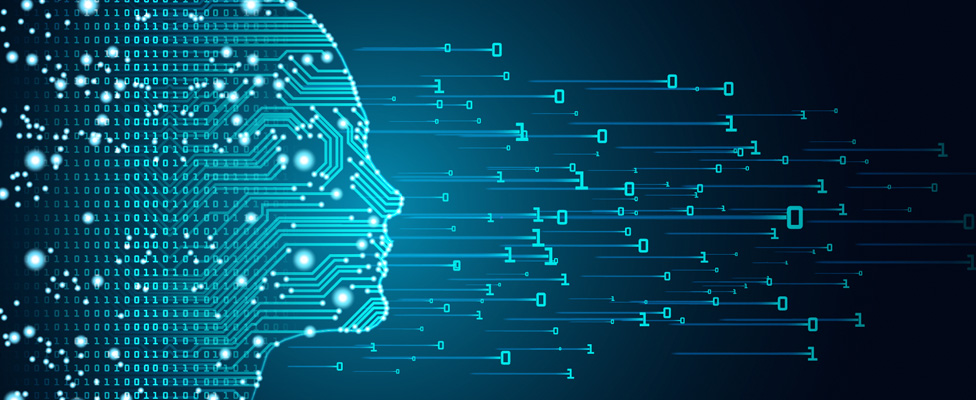

The goal of this practical course is to understand how transformers work for image classification and how to train them. 
We will work on a problem of image classification of plankton images.
First we will study the data and in particular their distribution. Then we will train convnets and transformers for the classification of these images. We will then analyze the predictions in order to improve the models.

## Test GPU

We check that we have access to a GPU and we look at what memory it has in order to better adjust our batch size.

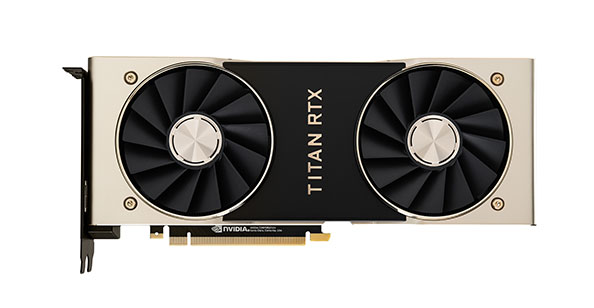

In [ ]:
!nvidia-smi

## Data preparation

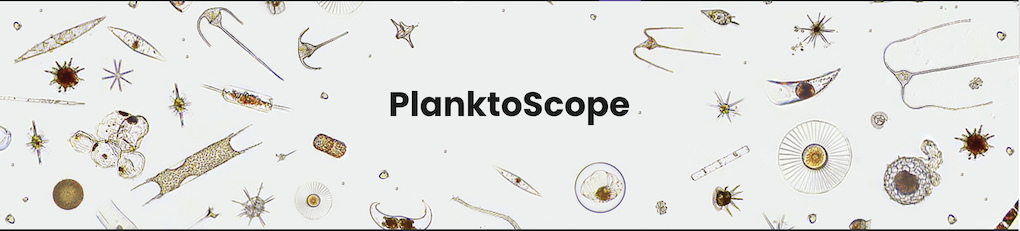

In [ ]:
cd /home/ml4oceans24/experiments

In [ ]:
import sys,os,os.path
os.environ['HTTP_PROXY']="192.168.0.100:3128"
os.environ['HTTPS_PROXY']="192.168.0.100:3128"

## Data-exploration

We will analyze the data we have. In particular we will visualize the images and look at the distribution of the classes.

In [ ]:
import pandas as pd
from PIL import Image
import os
import os.path as osp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore")

### features & labels explorations

In [ ]:
features = pd.read_csv('/home/ml4oceans24/experiments/planktoscope_ml4oceans/features.csv')
labels = pd.read_csv('/home/ml4oceans24/experiments/planktoscope_ml4oceans/labels.csv')

In [ ]:
features

In [ ]:
labels

#### Data distributions

In [ ]:
labels['label'].value_counts()

#### Data distribution

**Exercise: Plot the data distributions by classes**




In [ ]:
#ANSWER

#### Data distribution without detritus

**Exercise: Plot the data distributions by classes without the class detritus**

In [ ]:
#ANSWER

### Images explorations

In [ ]:
def images_exploration(image_index = 0):
  image_path = osp.join('/home/ml4oceans24/experiments/planktoscope_ml4oceans/images',labels.iloc[image_index]['image'])
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  print(f"label: {labels.iloc[image_index]['label']}, images shapes: {img.shape[0]} x {img.shape[1]}")

interact(images_exploration, image_index=widgets.IntSlider(min=0, max=labels.shape[0], step=1, value=0));

### Train - Test - Val splits

In [ ]:
dict_images_by_labels = {}

for lab in labels['label'].values:
  dict_images_by_labels[lab] = []

for index in range(labels.shape[0]):
  dict_images_by_labels[labels.iloc[index]['label']].append(labels.iloc[index]['image'])

In [ ]:
test_sample = []
id_to_lab = {}
for i, lab in enumerate(dict_images_by_labels.keys()):

  all_samples = dict_images_by_labels[lab][:10]
  id_to_lab[i] = lab

  for path in all_samples:
    test_sample.append((osp.join('/home/ml4oceans24/experiments/planktoscope_ml4oceans/images',path),i))


The classes in the dataset are very unbalanced. In order to have a better interpretation of the results we have chosen to use a test set with a uniform distribution for the different classes.

**Exercise: adjust your training set**

In [ ]:
val_sample = []
train_sample = []
max_images_by_labels = #ANSWER (for instance 70)

for i, lab in enumerate(dict_images_by_labels.keys()):

  all_samples = dict_images_by_labels[lab][10:]

  for path in all_samples[:10]:
    val_sample.append((osp.join('/home/ml4oceans24/experiments/planktoscope_ml4oceans/images',path),i))

  end = min(len(all_samples),max_images_by_labels)

  for path in all_samples[10:end]:
    train_sample.append((osp.join('/home/ml4oceans24/experiments/planktoscope_ml4oceans/images',path),i))


## PyTorch dataset loader

We define here a PyTorch data-loader that takes as input a list of tuples of type (image paths, classes id) 

In [ ]:
import os
import json

from torchvision import datasets, transforms
from torchvision.datasets.folder import ImageFolder, default_loader

In [ ]:
class PlanktoDataset(ImageFolder):
    def __init__(self, samples=None, transform=None, target_transform=None, loader=default_loader):
        self.transform = transform
        self.loader = loader
        self.target_transform = target_transform
        self.samples = samples
        print(f"dataset size = {len(self.samples)}")


## Architecture

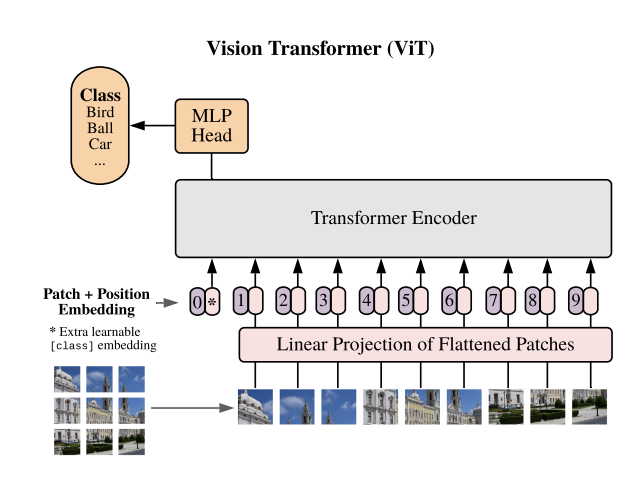

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from functools import partial

from timm.models.vision_transformer import PatchEmbed , _cfg

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

The position encoding in transformers depends on the size of the input. So we have to resize it if we use a pre-trained model at a different resolution.


**Exercise: code the function to interpolate the position en coding**


In [ ]:
def resize_pos_embed(posemb, posemb_new):
    ''''
    inputs:
    posemb: Tensor 1 x Number of tokens (pre-trained resolution) x working dim
    posemb is pre-trained

    posemb_new: Tensor 1 x Number of tokens current resolution) x working dim
    posemb_new is random 

    outputs:
    a position encoding of size 1 x Number of tokens current resolution) x working dim
    with an interpolation of the parameters of posemb.
    '''
    ## ANSWER
    return posemb_grid

We define here a function in order to load a pre-trained checkpoint

In [ ]:
def load_checkpoint(model, pretrained_dict):
    model_dict = model.state_dict()
    for k in model_dict.keys():
        if(('module.'+k) in pretrained_dict.keys()):
            if model_dict[k].size()==pretrained_dict.get(('module.'+k)).size():
                model_dict[k]=pretrained_dict.get(('module.'+k))
       
        else:

            if(k in pretrained_dict.keys()):
                if model_dict[k].size()==pretrained_dict.get(k).size():
                    model_dict[k]=pretrained_dict.get(k)
                else:
                    print('keys '+str(k)+' erase no load from checkpoint')
            else:
                print('keys '+str(k)+' missing')


    try:           
        if not pretrained_dict['module.pos_embed'].size() == model_dict['pos_embed'].size():
            pos_current = pretrained_dict['module.pos_embed']
            pos_future = model_dict['pos_embed']
            model_dict['pos_embed'] = resize_pos_embed(pos_current,pos_future)
    except:
        print('no pos_embed')
    return model_dict
    

We define here the attention module of transformers:

$x$: Tensor - Batch size (B) $\times$ Number of tokens (N) $\times$ working dimensions (d)

σ: softmax

$n_h$: #nb heads

h: $\frac{d}{n_h}$

$q = W_q x + b_q$

$k = W_k x + b_k$

$v = W_v x + b_v$

$W_a: σ(qk^T/\sqrt h)$

$out = W_o (W_a V)^T + b_o$

**Exercise: code the attention module**


In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        #ANSWER add your code here
        return x

We define the feed forward network of transformers (FFN). This is a multi-layers perceptron.

$W_1 x + b_1$

$GELU(x)$

$W_2 x + b_2$

**Exercise: code the MLP for transformers**

In [ ]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, bias=True, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        #ANSWER add your code here
        return x

We define here the transformers main block:

$ x + ATTN(LN(x))$

$ x + MLP(LN(x))$


In [ ]:
class Layer_scale_init_Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,Attention_block = Attention,Mlp_block=Mlp
                 ,init_values=1e-4):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention_block(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp_block(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)

    def forward(self, x):
        x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x)))
        x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

In [ ]:


    
class vit_models(nn.Module):
    """ Vision Transformer with LayerScale (https://arxiv.org/abs/2103.17239) support
    taken from https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
    with slight modifications
    """
    def __init__(self, img_size=224,  patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., norm_layer=nn.LayerNorm, global_pool=None,
                 block_layers = Layer_scale_init_Block,
                 Patch_layer=PatchEmbed,act_layer=nn.GELU,
                 Attention_block = Attention, Mlp_block=Mlp,
                dpr_constant=True,init_scale=1e-4,
                mlp_ratio_clstk = 4.0):
        super().__init__()
        
        self.dropout_rate = drop_rate

            
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = Patch_layer(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

        dpr = [drop_path_rate for i in range(depth)]
        self.blocks = nn.ModuleList([
            block_layers(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=0.0, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                act_layer=act_layer,Attention_block=Attention_block,Mlp_block=Mlp_block,init_values=init_scale)
            for i in range(depth)])
        

        
            
        self.norm = norm_layer(embed_dim)

        self.feature_info = [dict(num_chs=embed_dim, reduction=0, module='head')]
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head
    
    def get_num_layers(self):
        return len(self.blocks)
    
    def reset_classifier(self, num_classes):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        
        x = x + self.pos_embed
        
        x = torch.cat((cls_tokens, x), dim=1)
            
        for i , blk in enumerate(self.blocks):
            x = blk(x)
            
        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):

        x = self.forward_features(x)
        
        if self.dropout_rate:
            x = F.dropout(x, p=float(self.dropout_rate), training=self.training)
        x = self.head(x)
        
        return x


    

In [ ]:


def deit_tiny_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,   **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    
    return model
    
    
def deit_small_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_small_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)

    return model

def deit_medium_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False, **kwargs):
    model = vit_models(
        patch_size=16, embed_dim=512, depth=12, num_heads=8, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers = Layer_scale_init_Block, **kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_medium_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model 

def deit_base_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_base_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model
    
def deit_large_patch16_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=Layer_scale_init_Block, **kwargs)
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_large_'+str(224)+'_'
        if pretrained_21k:
            name+='21k.pth'
        else:
            name+='1k.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model
    
def deit_huge_patch14_LS(pretrained=False, img_size=224, pretrained_21k = False,  **kwargs):
    model = vit_models(
        img_size = img_size, patch_size=14, embed_dim=1280, depth=32, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers = Layer_scale_init_Block, **kwargs)
    if pretrained:
        name = 'https://dl.fbaipublicfiles.com/deit/deit_3_huge_'+str(224)+'_'
        if pretrained_21k:
            name+='21k_v1.pth'
        else:
            name+='1k_v1.pth'
            
        checkpoint = torch.hub.load_state_dict_from_url(
            url=name,
            map_location="cpu", check_hash=True
        )
        new_dict = load_checkpoint(model, checkpoint["model"])
        model.load_state_dict(new_dict)
    return model

## Training with pre-trained models

### Data-Augmentation

We define here the data-augmentation for training and evaluation of the model. If you finish earlier don't hesitate to test other kind of data-augmentation like RandomResizedCrop for the training or Tencrop for evaluation. See [Torchvision doc](https://pytorch.org/vision/stable/transforms.html).

In [ ]:
def get_transforms_test(input_size,crop = 1.0):
    mean, std = [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]
    Rs_size=int(input_size/crop) 
    transformations = {}
    transformations= transforms.Compose(
        [transforms.Resize(Rs_size, interpolation=3),
         transforms.CenterCrop(input_size),
         transforms.ToTensor(),
         transforms.Normalize(mean, std)])
    return transformations

def get_transforms_train(input_size,crop = 1.0):
    mean, std = [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]
    Rs_size=int(input_size/crop) 
    transformations = {}
    transformations= transforms.Compose(
        [transforms.Resize(Rs_size, interpolation=3),
         transforms.RandomCrop(input_size),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.0),
         transforms.ToTensor(),
         transforms.Normalize(mean, std)])
    return transformations    

### Datasets

We define here the batch size and image size

**Exercise: adjust batch size and image size**

In [ ]:
from torch.utils.data import DataLoader

batch_size = #ANSWER adjust batch size (for instance 256)
image_size = #ANSWER adjust image size (for instance 128)

training_data = PlanktoDataset(train_sample, get_transforms_train(image_size))

test_data = PlanktoDataset(test_sample, get_transforms_test(image_size))

val_data = PlanktoDataset(val_sample, get_transforms_test(image_size))



train_dataloader = DataLoader(training_data, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              drop_last = True)

test_dataloader = DataLoader(test_data, 
                             batch_size=batch_size, 
                             shuffle=False)

val_dataloader = DataLoader(val_data,
                            batch_size=batch_size,
                            shuffle=False)

total_step = len(training_data) // batch_size

#### Fonction to evaluate the models

We define the function to evaluate our architectures

In [ ]:
import time
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.reshape(1, -1).expand_as(pred))
        return [correct[:k].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

def validate(val_loader, model):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    criterion = nn.CrossEntropyLoss()

    target_list = []
    pred_list = []



    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        last_idx = len(val_loader) - 1
        for i, (images, target) in enumerate(val_loader):
            batch_idx = i
            last_batch = batch_idx == last_idx
            images = images.cuda()
            target = target.cuda()

            # compute output
            with torch.cuda.amp.autocast(enabled = False):
                output = model(images)
                loss = criterion(output, target)


            # measure accuracy and record loss
            try:
                acc1, acc5 = accuracy(output, target, topk=(1, 5))
            except:
                acc1, acc5 = accuracy(output, target, topk=(1, 2))
                
            reduced_loss = loss.data
            target_list.extend(target.cpu().reshape(-1).tolist())
            pred_list.extend(output.detach().cpu().argmax(dim=-1).reshape(-1).tolist())
            losses.update(reduced_loss.item(), images.size(0))
            top1.update(acc1.item(), images.size(0))
            top5.update(acc5.item(), images.size(0))

            batch_time.update(time.time() - end)
            end = time.time()





        print('* Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f} loss {losses.avg:.3f}'
              .format(top1=top1, top5=top5, losses=losses))

    return pred_list, target_list

#### Model selection 

**Exercise: choose the model you want to train and the part of the network you want to train**

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights

finetune_fc_only = #ANSWER for instance False to train the full model
model_type = #ANSWER for instance "deit-s"

nb_classes = len(list(dict_images_by_labels.keys()))

if model_type == "deit-s":
  model = deit_small_patch16_LS(pretrained=True, img_size=image_size, pretrained_21k = True)
  model.reset_classifier(nb_classes)
  for name_p , p in model.named_parameters():
    p.requires_grad = not finetune_fc_only

  model.head.weight.requires_grad = True
  model.head.bias.requires_grad = True
elif model_type == "resnet50":
  model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(2048,nb_classes)
  for name_p , p in model.named_parameters():
    p.requires_grad = not finetune_fc_only

  model.fc.weight.requires_grad = True
  model.fc.bias.requires_grad = True
else:
  model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(512,nb_classes)

  for name_p , p in model.named_parameters():
    p.requires_grad = not finetune_fc_only

  model.fc.weight.requires_grad = True
  model.fc.bias.requires_grad = True
model.cuda()

#### Optimizer

In [ ]:
import numpy as np

def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0, start_warmup_value=0):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

    schedule = np.concatenate((warmup_schedule, schedule))
    assert len(schedule) == epochs * niter_per_ep
    return schedule


We define the optimizer and the learning rate scheduler for our training

In [ ]:
from torch import optim as optim

nb_epochs = 20
lr = 1e-4
min_lr = 1e-6
optimizer =  optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01)

#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3,8,12], gamma=0.1)
lr_schedule = cosine_scheduler(
        lr,  
        min_lr,
        nb_epochs, len(train_dataloader),
        warmup_epochs=3,
    )


In order to reduce memory consumption it is possible to train the model with a smaller floating pointrepresentation (FLOAT 16)

In [ ]:
from timm.utils import NativeScaler
loss_scaler = NativeScaler()
max_norm = 1.0
fp16 = True

Label smoothing, cutmix and Mixup are some very popular training recipes in order to have good performance with vision transformers

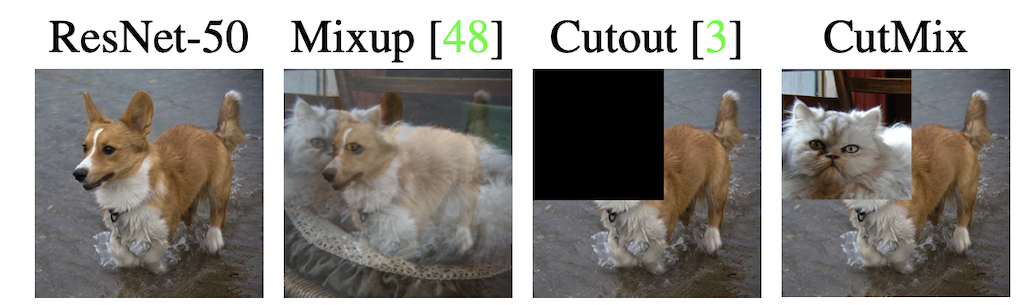

In [ ]:
from timm.data import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

loss_fn = LabelSmoothingCrossEntropy(0.1)

mixup_fn = None
mixup_active = True
if mixup_active:
    mixup_fn = Mixup(
        mixup_alpha=0.8, cutmix_alpha=1.0, cutmix_minmax=None,
        prob=1.0, switch_prob=0.5, mode='batch',
        label_smoothing=0.1, num_classes=nb_classes)
    loss_fn = SoftTargetCrossEntropy()

#### Training

**Exercise : Adjust all training hyperparameters in order to improve the model accuracy.**

Hparams and architecture:
- fp16 (True or False)
- finetune_fc_only (True or False)
- max_norm
- image_size
- batch_size
- nb_epochs
- warmup_epochs
- lr
- mixup_alpha
- cutmix_alpha
- architecture (in the last question you have to visualize attention maps it's easier with transformers 😉)
- adjust you training set
- drop_path_rate (for transformers only)

(The parameters to modify are in the previous cell)

In [ ]:
MB = 1024.0 * 1024.0

running_loss = 0
start_time = time.time()
log_freq = 3
for epoch in range(nb_epochs):
    optimizer.zero_grad()
    model.train()
    for step, data in enumerate(train_dataloader):

        # The 3 following line are only for cosine scheduler you can comment them if you are using a PyTorch scheduler
        it = len(train_dataloader) * epoch + step  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]

        input, target = data
        input = input.cuda()
        target = target.cuda()
        if mixup_fn is not None:
            input, target = mixup_fn(input, target)

        with torch.cuda.amp.autocast(enabled = fp16):
          output = model(input)
          loss = loss_fn(output, target)
        
        
        if fp16:
          optimizer.zero_grad()
          loss_scaler(loss, optimizer, clip_grad=max_norm,
                      parameters=model.parameters(), create_graph=False)
        else:
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

        
        running_loss += loss.item()
        if (step + 1)%log_freq == 0:
          memory_usage = torch.cuda.max_memory_allocated() / MB
          print(f"{epoch}:{step}/{total_step}, loss:{running_loss/log_freq},lr: {optimizer.param_groups[0]['lr']:.8f}, mem: {memory_usage:.1f} MB, {time.time()-start_time:.2f} s")
          running_loss = 0
          start_time = time.time()

    #scheduler.step() # this line is for PyTorch scheduler uncoment this line if you use PyTorch scheduler
    if epoch%1 ==0:
      validate(val_dataloader,model)



**Exercise: add a code to save and load your models [PyTorch doc](https://pytorch.org/tutorials/beginner/saving_loading_models.html)**

In [ ]:
#ANSWER

In [ ]:
print("Evaluation on the train set")
validate(train_dataloader,model)
print()
print("Evaluation on the val set")
validate(val_dataloader,model)
print()

In [ ]:
print("Evaluation on the test set")
y_pred, y_true = validate(test_dataloader,model)

**Exercise: report your best accuracy with a DeiT-S and a ResNet18**

Answer add you results here

#### Confusion matrix

We want to visualize the confusion matrix  in order to interpret the prediction errors.

**Exercise: Plot the confusion matrix of the prediction on the test set**

You can use:

`from sklearn.metrics import confusion_matrix`

`confusion_matrix(y_true, y_pred)`

In [ ]:
# ANSWER plot the confusion matrix 

### Explore prediction

In [ ]:
def images_exploration(image_index = 0):
  image_path = osp.join('/home/ml4oceans24/experiments/planktoscope_ml4oceans/images',labels.iloc[image_index]['image'])
  img = plt.imread(image_path)
  imgplot = plt.imshow(img)
  im = Image.open(image_path)
  im = get_transforms_test(image_size)(im)
  model.eval()
  with torch.no_grad():
    with torch.cuda.amp.autocast(enabled = True):
      out = model(im.unsqueeze(0).cuda())
      out = out.softmax(dim=-1)
      ind = int(out.cpu().argmax(dim=-1).reshape(-1))
      probs = float(out.cpu().max())
  
  print(f"label: {labels.iloc[image_index]['label']}, images shapes: {img.shape[0]} x {img.shape[1]}, predicted label: {id_to_lab[ind]} ({probs*100:.2f}%)")

interact(images_exploration, image_index=widgets.IntSlider(min=0, max=labels.shape[0], step=1, value=0));

### Visualize attention maps

We want to visualize the attention map for each layer and each head of the model. You have to code a function that allows you to do that. Below is an example with:
original image, attention map interpolated on the original image and plot of the attention map matrix.

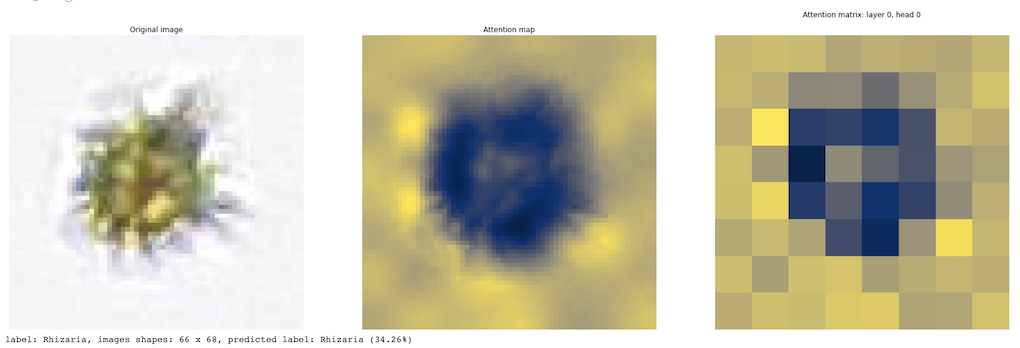

**Exercise: visualize attention maps**

In [ ]:
#ANSWER

## Further Exercise

Try to improve the performance for the classification image task:

- Implement ensembling of different architecture: train 2-3 architectures on the image classication task and merge the prediction in order to have better performance

- Distillation can be very usefull with transformers. Implement transformers training with knowledge distillation. First, you have to train a ResNet18 on the classification task and use the prediction of this model during the transformer training.

In [ ]:
#ANSWER

In [ ]:
#ANSWER